Connected to piratefmri (Python 3.9.16)

sub0/39: 0en2YwrgPZqq
sub1/39: CIHofsSopOIK
sub2/39: Dg4Z9j33pfaS
sub3/39: ESg8ssLdSeH4
sub4/39: FZy8PSATlIm3
sub5/39: G8yNoK8WMiwt
sub6/39: GsxAkjUf8C3h
sub7/39: H4wAVOPtFkAT
sub8/39: H8eke7rnGDxC
sub9/39: Kp1cBGB5cVB1
sub10/39: LYXb3l48KVDg
sub11/39: LaShetB8zSzf
sub12/39: M5uurHuWl0gO
sub13/39: MJQxtcr3UsX3
sub14/39: MmKPMPR6SFsd
sub15/39: NzlkkO2C4ye1
sub16/39: QeAvxrNgN6Js
sub17/39: RAVplkWmRefi
sub18/39: RcwaTugr8Fiz
sub19/39: SyZeCxfhSm2n
sub20/39: UQoUjJ6BxXdi
sub21/39: WOcbffbfi7mI
sub22/39: X85XeGbFw5y3
sub23/39: YHFTln2WomAo
sub24/39: aprCv5rFL8pN
sub25/39: bHAKEOQOX39l
sub26/39: bjjQPvQtZ124
sub27/39: e5F59k07mWB9
sub28/39: l5kKVclV7Cy9
sub29/39: p069BDbHBA7C
sub30/39: p0lVvTw5pPFU
sub31/39: pyf3Hd3NVa50
sub32/39: rRFXwgxK5NUQ
sub33/39: rkUOlfyTeHAM
sub34/39: s2Fep00o4Qtn
sub35/39: syF1CdxD5IPj
sub36/39: tXmcOBQcBq5X
sub37/39: wVXlXrIhxhRE
sub38/39: xZoeR59rDXFN


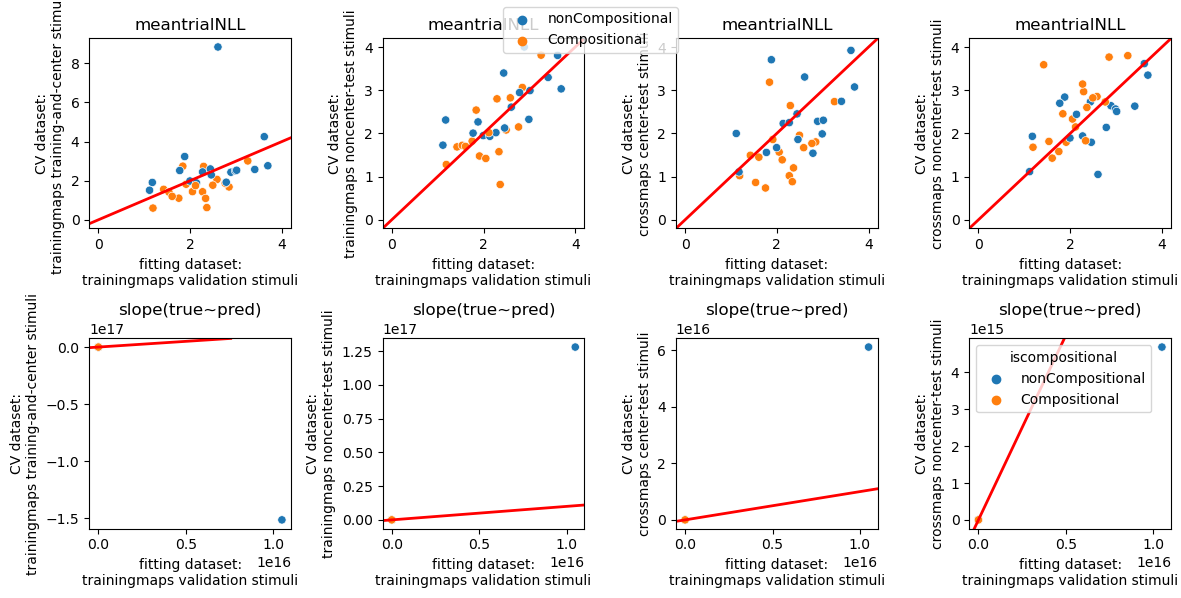

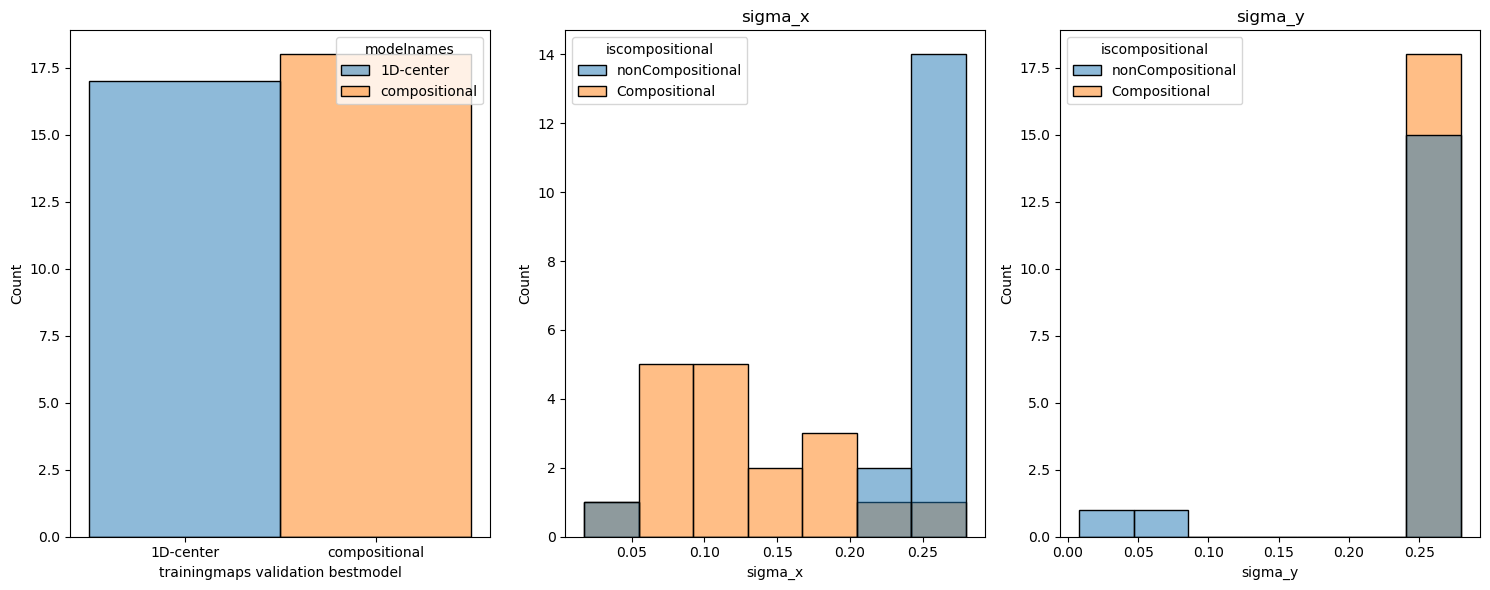

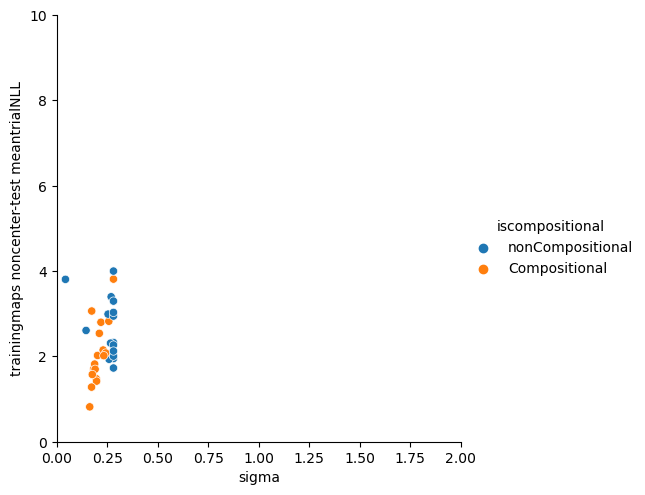

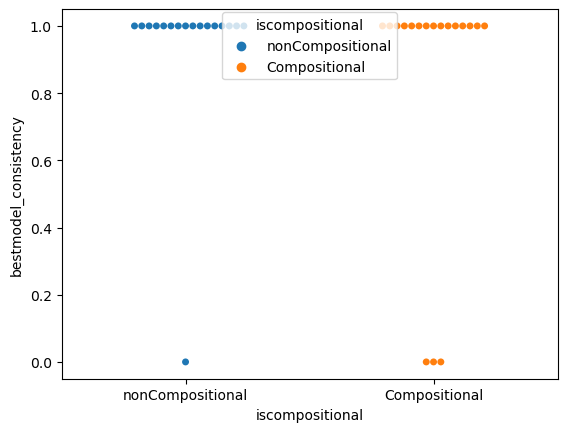

In [2]:
import numpy as np
import scipy.stats
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import scipy
import itertools
project_dir = "E:\pirate_fmri\Analysis"
import sys
sys.path.append(project_dir)
from src.utils.composition_modelfit import *
from scipy.optimize import minimize
from joblib import Parallel,delayed,dump,load

study_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\3_M2_V2"
data_dir = os.path.join(study_dir,"data","json")
param_dir = os.path.join(study_dir,"data","param")

org_data = pd.read_csv(os.path.join(study_dir,"task_data.csv"))
valid_exptid = np.unique(org_data.subid)

# rescale stim_xy and respone
range_stimxy = [np.max(org_data.stim_x) - np.min(org_data.stim_x),
                np.max(org_data.stim_y) - np.min(org_data.stim_y)]
org_data["stim_xO"] = org_data.stim_x
org_data["stim_yO"] = org_data.stim_y
org_data["resp_xO"] = org_data.resp_x
org_data["resp_yO"] = org_data.resp_y
org_data["stim_x"]  = [np.round(2*a/range_stimxy[0],decimals = 3) for a in org_data.stim_xO.to_numpy()]
org_data["stim_y"]  = [np.round(2*a/range_stimxy[1],decimals = 3) for a in org_data.stim_yO.to_numpy()]
org_data["resp_x"]  = [np.round(2*a/range_stimxy[0],decimals = 3) for a in org_data.resp_xO.to_numpy()]
org_data["resp_y"]  = [np.round(2*a/range_stimxy[0],decimals = 3) for a in org_data.resp_yO.to_numpy()]


putativerespdata_test = []
for id in valid_exptid:
    subdf = org_data[(org_data.subid==id)&(org_data.ctrl_ept==1)].copy().reset_index(drop=True)
    
    # find the final block of each map in test
    n_pretrain_permap = 8
    n_map = 2
    n_refresh_permap = 4
    test_block_idx = n_pretrain_permap*n_map+n_refresh_permap
    sub_testblock_df = subdf[(subdf.expt_session==1)&(subdf.expt_block==test_block_idx)].copy().reset_index(drop=True)
    #sub_testblock_df.groupby(["subid","expt_map","x_axisset","y_axisset","stim_group","istraining","stim_id","stim_x","stim_y"])[["resp_x","resp_y"]].mean().reset_index()
    # the data frame used to derive putative response
    sub_trainingresp=sub_testblock_df[sub_testblock_df.istraining==True].copy().reset_index(drop=True)
    sub_resp=sub_testblock_df.copy()
    
    putative_xs = compose_pattern_from_reference(sub_resp[["stim_x"]].to_numpy(),
                                sub_trainingresp[["resp_x"]].to_numpy(),
                                sub_trainingresp[["stim_x"]].to_numpy(),
                                source_controlfeatures=sub_resp[["x_axisset"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["x_axisset"]].to_numpy()).flatten()
    putative_ys = compose_pattern_from_reference(sub_resp[["stim_y"]].to_numpy(),
                                sub_trainingresp[["resp_y"]].to_numpy(),
                                sub_trainingresp[["stim_y"]].to_numpy(),
                                source_controlfeatures=sub_resp[["y_axisset"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["y_axisset"]].to_numpy()).flatten()
    sub_resp["putative_x"] = [truex if istraining else putativex for putativex,truex,istraining in zip(putative_xs,sub_resp.stim_x.to_numpy(),sub_resp.istraining.to_numpy())]
    sub_resp["putative_y"] = [truey if istraining else putativey for putativey,truey,istraining in zip(putative_ys,sub_resp.stim_y.to_numpy(),sub_resp.istraining.to_numpy())]
    sub_resp["map_axes"] = [f"{x}_{y}" for x,y in sub_resp[["x_axisset","y_axisset"]].to_numpy()]
    putativerespdata_test.append(sub_resp)

putativerespdata_test_df = pd.concat(putativerespdata_test).reset_index(drop=True)
putativerespdata_test_df["iscenter"] = pd.Categorical([x*y==0 for x,y in putativerespdata_test_df[["stim_x","stim_y"]].to_numpy()]).rename_categories(
    {True:"center",False:"noncenter"}
)


################# RUN MODEL FITTING ##############################
run_fit = False
# arena parameters
arena_r = (5 + (1.42*60/53*1.1/2))*(2/range_stimxy[0])
err_tol = 1.05*60/53 *(2/range_stimxy[0]) # take into account the pirate size

# models to fit
model_xystrategies = { # in the form of xstrategy-ystrategy
        "compositional": ["putative-putative"],
        "1D-center":["putative-bias","bias-putative"],
        "1D-random":["putative-random","random-putative"]
    }
model_paramnames = {
    "noncompo-random":[],
    "compositional": ["sigma_x", "sigma_y","lapse_rate"], # "betax", "betay", 
    "1D-center":     ["sigma_x", "sigma_y", "sigma_biasx", "sigma_biasy","lapse_rate"],
    "1D-random":     ["sigma_x", "sigma_y","lapse_rate"]
}
beta_bounds = (0.1,arena_r)
sigma_bounds = (1e-20,err_tol) 
sigmabias_bounds = (1e-20,arena_r)     
mu_bounds = (-arena_r,arena_r)
lapse_bounds = (0,0.1)
model_bounds = {
    "compositional": [sigma_bounds,sigma_bounds,lapse_bounds],
    "1D-center":[sigma_bounds,sigma_bounds,sigmabias_bounds,sigmabias_bounds,lapse_bounds],
    "1D-random":[sigma_bounds,sigma_bounds,lapse_bounds]
}
unique_param_names = np.unique(sum(list(model_paramnames.values()),[]))

fixedparams = {     
                "noncompo-random":{},
                "compositional":  {"betax":1,"betay":1},
                "1D-center":      {"betax":1,"betay":1,"biasx":0, "biasy":0},
                "1D-random":      {"betax":1,"betay":1,"biasx":0, "biasy":0} # "lapse_rate":0.05
            }
all_param_names = np.array(list(unique_param_names) + ["betax", "betay","biasx","biasy"])

outout_fn = "fitted_bhavmodel_parameters_tvsplit_centerality"
if run_fit:
    fit_param = []
    for j,id in enumerate(valid_exptid):
        subdf = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group=="validation")&(putativerespdata_test_df.expt_map.isin([0,1]))].copy().reset_index(drop=True)
        #trainstim_df = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group=="training")&(putativerespdata_test_df.expt_map.isin([0,1]))].copy().reset_index(drop=True)
        #mu_respx = np.mean(trainstim_df[trainstim_df.stim_x==0].resp_x)
        #mu_respy = np.mean(trainstim_df[trainstim_df.stim_y==0].resp_y)
        #fixedparams["1D-center"].update({"biasx":mu_respx, "biasy":mu_respy})
        
        fit_data = subdf[["resp_x","resp_y","putative_x","putative_y"]].to_numpy()
        
        #estimate starting value for optimisation
        bx, ix, _, _, _  = scipy.stats.linregress(fit_data[:,0], fit_data[:,2])
        by, iy, _, _, _  = scipy.stats.linregress(fit_data[:,1], fit_data[:,3])  
        bx,by = 1,1
        sig_x = np.power(fit_data[:,0] - bx*fit_data[:,2],2).mean()
        sig_y = np.power(fit_data[:,1] - by*fit_data[:,3],2).mean()

        sigbias_x = np.power(fit_data[:,0] - 0,2).mean()
        sigbias_y = np.power(fit_data[:,1] - 0,2).mean()

        model_x0 = {
            "compositional": [sig_x,sig_y,0.05],
            "1D-center":     [sig_x,sig_y,sigbias_x,sigbias_y,0.05],
            "1D-random":     [sig_x,sig_y,0.05]
        }

        all_model_fit = []
        for mname, xystrategies in model_xystrategies.items():
            print(f"\nsub{j+1}/{np.size(valid_exptid)}: {id} {mname}")

            # fit_output = multi_start_optimisation(compute_llr_across_trials,
            #                         bounds=model_bounds[mname],
            #                         args=(model_paramnames[mname],xystrategies,fit_data,fixedparams[mname]),
            #                         Ns=3,n_jobs=1)
            fit_output = wise_start_optimisation(compute_llr_across_trials,
                                    bounds=model_bounds[mname],
                                    args=(model_paramnames[mname],xystrategies,fit_data,fixedparams[mname]),
                                    x0=model_x0[mname],
                                    minimize_args={})
            print(f"  fitted {model_paramnames[mname]} = {fit_output[0]}, nll = {fit_output[1]}")
            all_model_fit.append(fit_output)
        fit_param.append(all_model_fit)
    dump({"subids":valid_exptid,"fit_param":fit_param,"fixedparams":fixedparams},os.path.join(study_dir,f"{outout_fn}.pkl"))


################# CHECK MODEL FIT ##############################
check_fit = True
if check_fit:
    fitted_data  = load(os.path.join(study_dir,f"{outout_fn}.pkl"))
    fixedparams  = fitted_data["fixedparams"]
    valid_exptid = fitted_data["subids"]
    fit_param    = fitted_data["fit_param"]

    model_xystrategies["noncompo-random"] = ["random-random"]

    model_selection_dfs = []
    model_param_dfs = []
    for jid,(id,fit_output) in enumerate(zip(valid_exptid,fit_param)):
        print(f"sub{jid}/{len(valid_exptid)}: {id}")
        fitted_param = dict(zip(
            list(model_xystrategies.keys())+["noncompo-random"],
            [o[0] for o in fit_output]+[[]]
        ))

        fitted_nll = dict(zip(
            list(model_xystrategies.keys())+["noncompo-random"],
            [o[1] for o in fit_output]+[[]]
        ))

        sub_df = putativerespdata_test_df[putativerespdata_test_df.subid == id].copy().reset_index(drop=True)
        
        df_split_criteria = { 
            "trainingmaps validation":          (sub_df.expt_map.isin([0,1]))&(sub_df.stim_group == "validation"), # dataset that is used to fit the parameter
            "trainingmaps training-and-center": (sub_df.expt_map.isin([0,1]))&(sub_df.iscenter == "center"),       # for sanity check
            "trainingmaps noncenter-test":      (sub_df.expt_map.isin([0,1]))&(sub_df.iscenter == "noncenter")&(sub_df.stim_group == "test"),    #
            "crossmaps center-test":            (sub_df.expt_map.isin([2,3]))&(sub_df.iscenter == "center"),
            "crossmaps noncenter-test":         (sub_df.expt_map.isin([2,3]))&(sub_df.iscenter == "noncenter"),
        }
        df_splits = {}
        data_splits = {}
        for k,v in df_split_criteria.items():
            df_splits[k] = sub_df[v].copy().reset_index(drop=True)
            data_splits[k] = df_splits[k][["resp_x","resp_y","putative_x","putative_y"]].to_numpy()
        
        data_nll = {}
        data_BIC = {}
        data_R2  = {}
        data_slope = {}
        n_random_sample = 500
        for sgname, ds in data_splits.items():
            data_nll[sgname] = {}
            data_BIC[sgname] = {}
            data_R2[sgname] = {}
            data_slope[sgname] = {}
            for mname, mstrategy in model_xystrategies.items():
                mparam = fitted_param[mname]
                data_nll[sgname][mname] = compute_llr_across_trials(mparam,model_paramnames[mname],model_xystrategies[mname],ds,fixedparams[mname])
                if np.logical_and(mname != "noncompo-random", sgname == "trainingmaps validation"):
                    returned_nll = fitted_nll[mname]
                    assert np.round(data_nll[sgname][mname],4) == np.round(returned_nll,4)
                n_trials = df_splits[sgname].shape[0]
                data_BIC[sgname][mname] = BIC(data_nll[sgname][mname],n_trials,len(mparam))

                param_dict = dict(zip(model_paramnames[mname],fitted_param[mname]))
                param_dict.update(fixedparams[mname])
                null_param_dict = dict(zip(all_param_names[[x not in param_dict.keys() for x in all_param_names]],
                                        [np.nan]*sum([x not in param_dict.keys() for x in all_param_names])))
                param_dict.update(null_param_dict)
                # predicted_resp is of shape (n_random_sample,2,ds.shape[0])
                predicted_resp = sample_response(param_dict, mstrategy, ds, sample_size=n_random_sample,seed=None)
                true_resp = ds[:,[0,1]]
                slpx = [calculate_regression(predicted_resp[ksample,0,:], true_resp[:,0]) for ksample in range(n_random_sample)]
                slpy = [calculate_regression(predicted_resp[ksample,1,:], true_resp[:,1]) for ksample in range(n_random_sample)]
                r2 = [calculate_r_squared_bivariate(predicted_resp[ksample,:,:].T, true_resp) for ksample in range(n_random_sample)]
                data_R2[sgname][mname] = np.mean(r2)
                data_slope[sgname][mname] = np.mean([(sx+sy)/2 for sx,sy in zip(slpx,slpy)])

        modelnames = list(model_xystrategies.keys())
        model_param_df_dict = {"modelnames":modelnames}
        for pname in unique_param_names:
            model_param_df_dict[pname] = [fitted_param[mname][model_paramnames[mname].index(pname)] if pname in model_paramnames[mname] else np.nan for mname in modelnames]
        
        for sgname in data_nll.keys():
            n_trials = df_splits[sgname].shape[0]            
            model_param_df_dict[f"{sgname} BIC"]          = [data_BIC[sgname][mname] for mname in modelnames]
            model_param_df_dict[f"{sgname} R2"]           = [data_R2[sgname][mname] for mname in modelnames]
            model_param_df_dict[f"{sgname} slope(true~pred)"] = [data_slope[sgname][mname] for mname in modelnames]
            model_param_df_dict[f"{sgname} meantrialNLL"] = [data_nll[sgname][mname]/n_trials for mname in modelnames]
            bmodel = list(data_BIC[sgname].keys())[np.argmin(list(data_BIC[sgname].values()))]
            model_param_df_dict[f"{sgname} bestmodel"] = [bmodel] * len(modelnames)

        model_param_dfs.append(
            pd.DataFrame(model_param_df_dict).assign(subid=id)
        )

    model_param_df = pd.concat(model_param_dfs,axis=0).reset_index(drop=True)
    model_param_df["iscompositional"] = pd.Categorical(
        model_param_df["trainingmaps validation bestmodel"] == "compositional"
    ).rename_categories({True: 'Compositional', False: 'nonCompositional'})
    model_param_df["bestmodel_consistency"] = model_param_df["trainingmaps validation bestmodel"] == model_param_df["trainingmaps noncenter-test bestmodel"]
        
    compositional_ids = np.unique(model_param_df[model_param_df.iscompositional=="Compositional"].subid)
    remove_sub = ["RcwaTugr8Fiz","FZy8PSATlIm3","SyZeCxfhSm2n","bHAKEOQOX39l"]
    keep_sub = [id for id in valid_exptid if id not in remove_sub]

    compositional_ids = [id for id in compositional_ids if id in keep_sub]
    noncompositional_ids = [id for id in keep_sub if id not in compositional_ids]

    best_fit_df = model_param_df[(model_param_df.modelnames==model_param_df["trainingmaps validation bestmodel"])&(~model_param_df.subid.isin(remove_sub))].copy().reset_index()

    x_dsname = 'trainingmaps validation' 
    compare_dsnames = ['trainingmaps training-and-center',
                        'trainingmaps noncenter-test',
                        'crossmaps center-test',
                        'crossmaps noncenter-test']
    compare_metrics = ["meantrialNLL","slope(true~pred)"]
    ax_lims = [[0,4],[0,1]]
    fig_modelfit, axes_modelfit = plt.subplots(len(compare_metrics),len(compare_dsnames),figsize=(12,6))
    for j, mtc in enumerate(compare_metrics):
        for k, y_dsname in enumerate(compare_dsnames):
            sns.scatterplot(best_fit_df,
                            x = f"{x_dsname} {mtc}",
                            y = f"{y_dsname} {mtc}",
                            hue="iscompositional",
                            ax = axes_modelfit[j,k])
            axes_modelfit[j,k].set_xlabel(f"fitting dataset:\n{x_dsname} stimuli")
            axes_modelfit[j,k].set_ylabel(f"CV dataset:\n{y_dsname} stimuli")
            axes_modelfit[j,k].set_title(mtc)
            axes_modelfit[j,k].axline((0, 0), (ax_lims[j][1], ax_lims[j][1]), linewidth=2, color='r')
            if np.logical_and(j == len(compare_metrics)-1,k == len(compare_dsnames)-1):
                figlgdhandles, figlgdlabels = axes_modelfit[j,k].get_legend_handles_labels()
            else:
                axes_modelfit[j,k].get_legend().remove()
            #axes_modelfit[j,k].set_aspect(1)
            #axes_modelfit[j,k].set_xlim(ax_lims[j])
            #axes_modelfit[j,k].set_ylim(ax_lims[j])
    
    fig_modelfit.legend(figlgdhandles, figlgdlabels, loc='upper center')
    fig_modelfit.tight_layout()

    pparams = ['sigma_x', 'sigma_y']
    fig_typedist, axes_typedist = plt.subplots(1,1+len(pparams),figsize=(15,6))
    sns.histplot(best_fit_df,
                x="trainingmaps validation bestmodel",
                hue="modelnames",
                ax=axes_typedist[0])
    for k,pp in enumerate(pparams):
        sns.histplot(best_fit_df,
                x=pp,
                hue="iscompositional",
                ax=axes_typedist[k+1])
        axes_typedist[k+1].set_title(pp)
    fig_typedist.tight_layout()

    best_fit_df["sigma"] = [sx if np.isnan(sy) else sy if np.isnan(sx) else (sx+sy)/2 for sx,sy in best_fit_df[["sigma_x","sigma_y"]].to_numpy()]
    gs_sigma = sns.relplot(
        best_fit_df,
        x="sigma",
        y="trainingmaps noncenter-test meantrialNLL",
        hue="iscompositional"
        )
    for ax in gs_sigma.axes.flatten():
        ax.set_xlim([0,2])
        ax.set_ylim([0,10])
        #ax.axline(xy1=[0,0],xy2=[13,13],c="k")

    fig_consistency,ax_consistency = plt.subplots(1,1)
    sns.swarmplot(
        best_fit_df,
        x="iscompositional",
        y="bestmodel_consistency",
        hue="iscompositional",
        ax=ax_consistency)
    sns.move_legend(ax_consistency,
                    loc="upper center",
                    bbox_to_anchor=(0.5,1.01))

In [3]:
compositional_ids

['CIHofsSopOIK',
 'Dg4Z9j33pfaS',
 'ESg8ssLdSeH4',
 'GsxAkjUf8C3h',
 'H4wAVOPtFkAT',
 'H8eke7rnGDxC',
 'Kp1cBGB5cVB1',
 'MJQxtcr3UsX3',
 'NzlkkO2C4ye1',
 'RAVplkWmRefi',
 'WOcbffbfi7mI',
 'YHFTln2WomAo',
 'aprCv5rFL8pN',
 'bjjQPvQtZ124',
 'rRFXwgxK5NUQ',
 'rkUOlfyTeHAM',
 'tXmcOBQcBq5X',
 'xZoeR59rDXFN']

In [4]:
len(compositional_ids)

18

In [5]:
noncompositional_ids

['0en2YwrgPZqq',
 'G8yNoK8WMiwt',
 'LYXb3l48KVDg',
 'LaShetB8zSzf',
 'M5uurHuWl0gO',
 'MmKPMPR6SFsd',
 'QeAvxrNgN6Js',
 'UQoUjJ6BxXdi',
 'X85XeGbFw5y3',
 'e5F59k07mWB9',
 'l5kKVclV7Cy9',
 'p069BDbHBA7C',
 'p0lVvTw5pPFU',
 'pyf3Hd3NVa50',
 's2Fep00o4Qtn',
 'syF1CdxD5IPj',
 'wVXlXrIhxhRE']

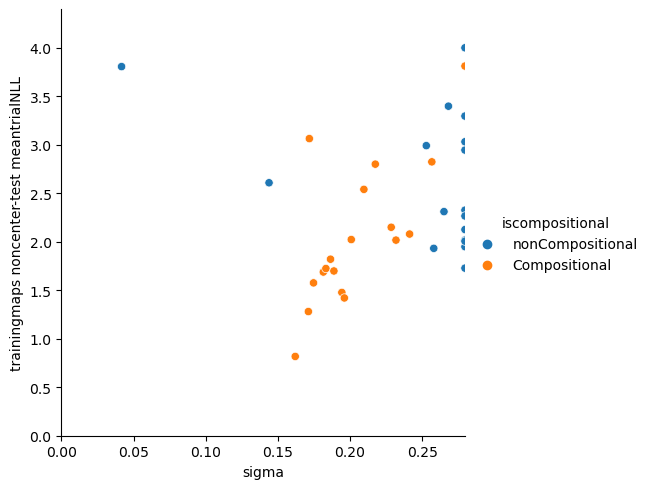

In [6]:
best_fit_df["sigma"] = [sx if np.isnan(sy) else sy if np.isnan(sx) else (sx+sy)/2 for sx,sy in best_fit_df[["sigma_x","sigma_y"]].to_numpy()]
gs_sigma = sns.relplot(
    best_fit_df,
    x="sigma",
    y="trainingmaps noncenter-test meantrialNLL",
    hue="iscompositional"
    )
for ax in gs_sigma.axes.flatten():
    ax.set_xlim([0,err_tol])
    ax.set_ylim([0,1.1*np.max(best_fit_df["trainingmaps noncenter-test meantrialNLL"])])
    #ax.axline(xy1=[0,0],xy2=[13,13],c="k")

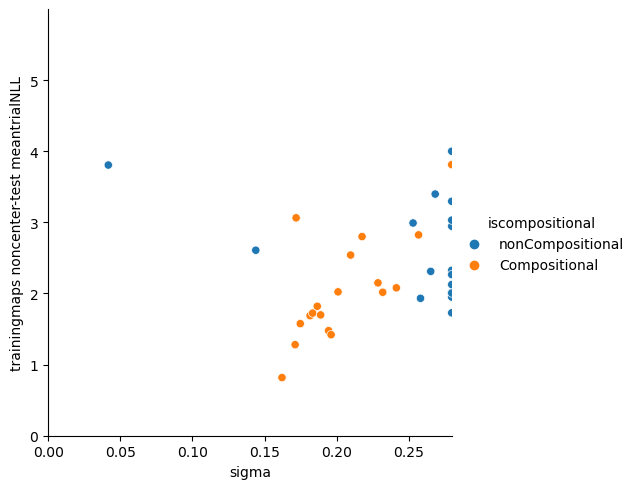

In [7]:
best_fit_df["sigma"] = [sx if np.isnan(sy) else sy if np.isnan(sx) else (sx+sy)/2 for sx,sy in best_fit_df[["sigma_x","sigma_y"]].to_numpy()]
gs_sigma = sns.relplot(
    best_fit_df,
    x="sigma",
    y="trainingmaps noncenter-test meantrialNLL",
    hue="iscompositional"
    )
for ax in gs_sigma.axes.flatten():
    ax.set_xlim([0,err_tol])
    ax.set_ylim([0,1.5*np.max(best_fit_df["trainingmaps noncenter-test meantrialNLL"])])
    #ax.axline(xy1=[0,0],xy2=[13,13],c="k")

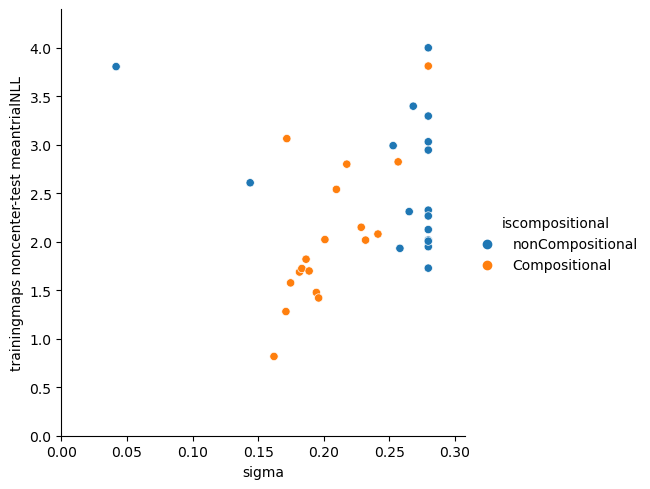

In [8]:
best_fit_df["sigma"] = [sx if np.isnan(sy) else sy if np.isnan(sx) else (sx+sy)/2 for sx,sy in best_fit_df[["sigma_x","sigma_y"]].to_numpy()]
gs_sigma = sns.relplot(
    best_fit_df,
    x="sigma",
    y="trainingmaps noncenter-test meantrialNLL",
    hue="iscompositional"
    )
for ax in gs_sigma.axes.flatten():
    ax.set_xlim([0,1.1*err_tol])
    ax.set_ylim([0,1.1*np.max(best_fit_df["trainingmaps noncenter-test meantrialNLL"])])
    #ax.axline(xy1=[0,0],xy2=[13,13],c="k")

In [9]:
predicted_resp.shape

(500, 2, 32)

In [10]:
slpx

[-0.05878664446607748,
 -0.011958437128718353,
 -0.0912210485006509,
 0.03596774412563801,
 0.015921725772368785,
 -0.10991034493199148,
 0.03429618038595161,
 -0.0008687520635544476,
 -0.08299550298353493,
 0.0013274359242067733,
 0.11516165109737216,
 0.08989241254776514,
 -0.11733439631415438,
 -0.014764846580158328,
 -0.12873733179537444,
 -0.06068524771038225,
 -0.057466715246664274,
 -0.000529310687036431,
 -0.0484882237932262,
 0.10712570309232888,
 -0.03930582266489929,
 -0.08259108108674193,
 -0.03029736390619283,
 0.012675103727492436,
 0.06223326675797737,
 0.007099613842476271,
 -0.002885890315333212,
 -0.03689884066555139,
 0.07677602982648618,
 -0.013456574773040898,
 -0.03572478468625147,
 -0.07769152252701769,
 -0.02181213124774893,
 -0.08332627444395704,
 0.09786505974055076,
 0.1604364825030919,
 -0.06644488635067439,
 0.110943977728474,
 0.020417583449941882,
 0.0043657644647729235,
 0.03176900582460332,
 0.04443864873671554,
 0.04290108245132782,
 0.1145591721496339

In [11]:
slpy

[-0.10659492828786947,
 0.06248288900896305,
 -0.06781582986160868,
 -0.012836828832647062,
 0.009494029437405929,
 0.0201761220685867,
 0.025207842859577136,
 0.020674855190611657,
 -0.002560936845536149,
 0.02184998709571903,
 0.002049232877289817,
 -0.007035341354169557,
 0.012295669197308786,
 -0.06515932159064998,
 -0.09681219436513969,
 0.025342038988110563,
 -0.10778956290368234,
 -0.035508185112405756,
 0.11593689953955783,
 0.07925089722824079,
 -0.02866484632211847,
 0.027008736967915496,
 -0.06061587604088067,
 -0.032751468123877504,
 -0.09188165688850768,
 0.001742020723254412,
 0.051592751880261564,
 -0.09191404283919875,
 0.004228675225409851,
 -0.010902768450527405,
 0.013052197845695652,
 0.04133600346272267,
 -0.007129879591700959,
 -0.060482423997099084,
 -0.003918099214220247,
 0.04406807932744411,
 0.05074877059485004,
 -0.15369889414024065,
 0.0068597899511430365,
 0.08919191974276862,
 -0.05308204725922974,
 0.014665292693384794,
 -0.04310814870497292,
 -0.0698958

In [12]:
np.mean(r2)

-0.1902167936478985

In [13]:
mname

'noncompo-random'

In [14]:
predicted_resp[ksample,0,:]

NameError: name 'ksample' is not defined

In [ ]:
predicted_resp[0,0,:]

array([ 2.03259173, -1.46433119, -2.32099782, -2.29999667, -2.4041169 ,
       -0.78147677, -1.62090585, -1.17077302,  0.06756528, -2.2621876 ,
        0.98965265, -0.56108538,  0.56083309,  2.39221416, -2.28142595,
       -1.15891083,  1.2115431 ,  2.41265815, -2.23417104, -2.1915689 ,
       -1.28939066,  2.33523035, -1.54792278,  2.3905402 ,  0.9109553 ,
        2.01818887, -2.37478033, -0.09213683,  1.12381104, -0.31279573,
       -2.03483076, -2.41614195])

In [ ]:
best_fit_df

,index,modelnames,lapse_rate,sigma_biasx,sigma_biasy,sigma_x,sigma_y,trainingmaps validation BIC,trainingmaps validation R2,trainingmaps validation slope(true~pred),...,crossmaps center-test bestmodel,crossmaps noncenter-test BIC,crossmaps noncenter-test R2,crossmaps noncenter-test slope(true~pred),crossmaps noncenter-test meantrialNLL,crossmaps noncenter-test bestmodel,subid,iscompositional,bestmodel_consistency,sigma
0,1,1D-center,0.100000,1.000000e-20,0.442393,0.279689,0.008108,97.247960,0.202775,3.148912e+14,...,1D-center,84.580950,0.128756,1.218976e+15,1.050817,1D-center,0en2YwrgPZqq,nonCompositional,True,0.143899
1,4,compositional,0.100000,NaN,NaN,0.155405,0.279689,81.714367,0.179329,3.269399e-01,...,compositional,200.224676,0.181655,2.908697e-01,2.966054,1D-center,CIHofsSopOIK,Compositional,False,0.217547
2,8,compositional,0.100000,NaN,NaN,0.279689,0.279689,112.498883,0.237196,3.863464e-01,...,compositional,253.541498,0.129294,2.511195e-01,3.799130,1D-center,Dg4Z9j33pfaS,Compositional,False,0.279689
3,12,compositional,0.100000,NaN,NaN,0.233746,0.279689,91.032606,0.262700,3.924677e-01,...,compositional,192.975827,0.151039,2.602549e-01,2.852791,compositional,ESg8ssLdSeH4,Compositional,True,0.256718
4,21,1D-center,0.100000,6.282166e-01,0.409167,0.017518,0.065870,129.553133,-0.067870,2.043250e-01,...,1D-center,248.663998,-0.059124,1.646100e-01,3.614614,compositional,G8yNoK8WMiwt,nonCompositional,True,0.041694
5,24,compositional,0.100000,NaN,NaN,0.109028,0.279689,69.507322,0.226882,4.036521e-01,...,compositional,125.335720,0.197036,2.984445e-01,1.795914,compositional,GsxAkjUf8C3h,Compositional,True,0.194359
6,28,compositional,0.100000,NaN,NaN,0.112500,0.279689,73.929165,0.125141,2.445090e-01,...,compositional,159.668300,0.121998,1.947283e-01,2.332361,compositional,H4wAVOPtFkAT,Compositional,True,0.196095
7,32,compositional,0.100000,NaN,NaN,0.122098,0.279689,80.986685,0.155993,2.727387e-01,...,compositional,211.457369,0.143805,2.154317e-01,3.141565,1D-center,H8eke7rnGDxC,Compositional,True,0.200894
8,36,compositional,0.100000,NaN,NaN,0.063983,0.279689,99.435126,0.199113,3.705258e-01,...,compositional,251.429401,0.097185,2.176702e-01,3.766128,1D-center,Kp1cBGB5cVB1,Compositional,False,0.171836
9,41,1D-center,0.100000,4.821647e-01,0.234361,0.279689,0.279689,106.298819,-0.062474,1.220330e-01,...,1D-center,186.286046,-0.056951,6.667184e-02,2.639959,1D-center,LYXb3l48KVDg,nonCompositional,True,0.279689


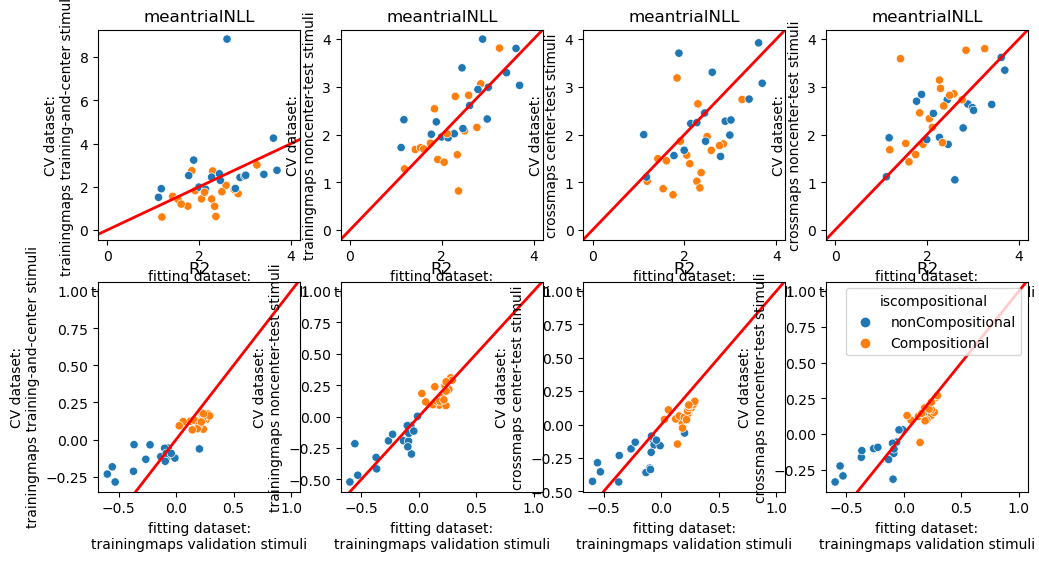

In [ ]:
x_dsname = 'trainingmaps validation' 
compare_dsnames = ['trainingmaps training-and-center',
                    'trainingmaps noncenter-test',
                    'crossmaps center-test',
                    'crossmaps noncenter-test']
compare_metrics = ["meantrialNLL","R2"]
ax_lims = [[0,4],[0,1]]
fig_modelfit, axes_modelfit = plt.subplots(len(compare_metrics),len(compare_dsnames),figsize=(12,6))
for j, mtc in enumerate(compare_metrics):
    for k, y_dsname in enumerate(compare_dsnames):
        sns.scatterplot(best_fit_df,
                        x = f"{x_dsname} {mtc}",
                        y = f"{y_dsname} {mtc}",
                        hue="iscompositional",
                        ax = axes_modelfit[j,k])
        axes_modelfit[j,k].set_xlabel(f"fitting dataset:\n{x_dsname} stimuli")
        axes_modelfit[j,k].set_ylabel(f"CV dataset:\n{y_dsname} stimuli")
        axes_modelfit[j,k].set_title(mtc)
        axes_modelfit[j,k].axline((0, 0), (ax_lims[j][1], ax_lims[j][1]), linewidth=2, color='r')
        if np.logical_and(j == len(compare_metrics)-1,k == len(compare_dsnames)-1):
            figlgdhandles, figlgdlabels = axes_modelfit[j,k].get_legend_handles_labels()
        else:
            axes_modelfit[j,k].get_legend().remove()
        #axes_modelfit[j,k].set_aspect(1)
        #axes_modelfit[j,k].set_xlim(ax_lims[j])
        #axes_modelfit[j,k].set_ylim(ax_lims[j])

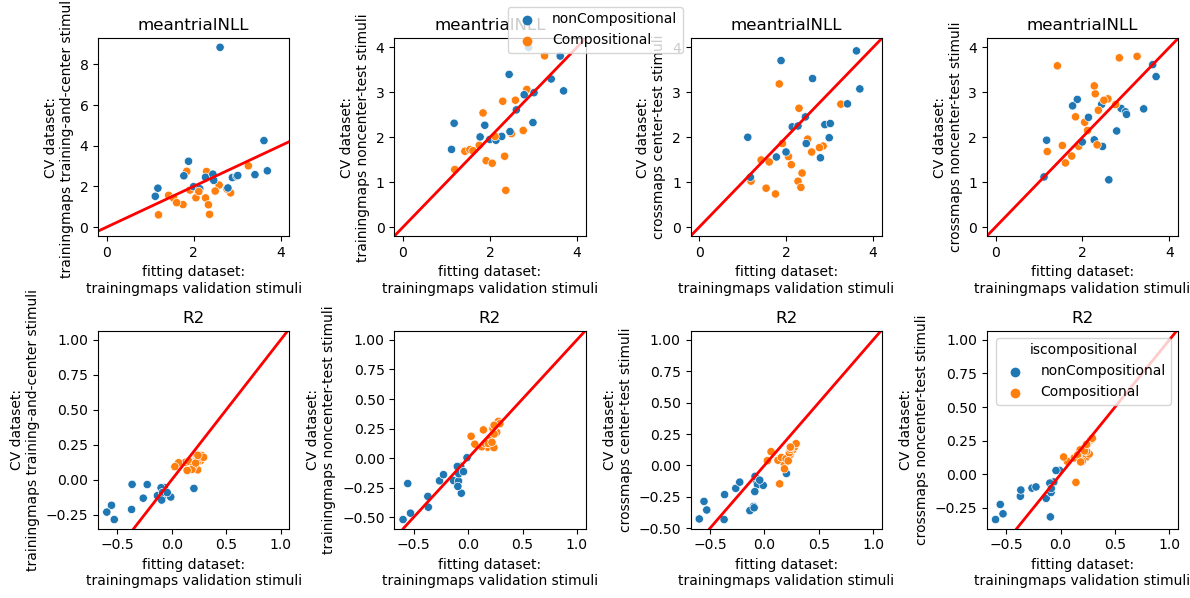

In [ ]:
x_dsname = 'trainingmaps validation' 
compare_dsnames = ['trainingmaps training-and-center',
                    'trainingmaps noncenter-test',
                    'crossmaps center-test',
                    'crossmaps noncenter-test']
compare_metrics = ["meantrialNLL","R2"]
ax_lims = [[0,4],[0,1]]
fig_modelfit, axes_modelfit = plt.subplots(len(compare_metrics),len(compare_dsnames),figsize=(12,6))
for j, mtc in enumerate(compare_metrics):
    for k, y_dsname in enumerate(compare_dsnames):
        sns.scatterplot(best_fit_df,
                        x = f"{x_dsname} {mtc}",
                        y = f"{y_dsname} {mtc}",
                        hue="iscompositional",
                        ax = axes_modelfit[j,k])
        axes_modelfit[j,k].set_xlabel(f"fitting dataset:\n{x_dsname} stimuli")
        axes_modelfit[j,k].set_ylabel(f"CV dataset:\n{y_dsname} stimuli")
        axes_modelfit[j,k].set_title(mtc)
        axes_modelfit[j,k].axline((0, 0), (ax_lims[j][1], ax_lims[j][1]), linewidth=2, color='r')
        if np.logical_and(j == len(compare_metrics)-1,k == len(compare_dsnames)-1):
            figlgdhandles, figlgdlabels = axes_modelfit[j,k].get_legend_handles_labels()
        else:
            axes_modelfit[j,k].get_legend().remove()
        #axes_modelfit[j,k].set_aspect(1)
        #axes_modelfit[j,k].set_xlim(ax_lims[j])
        #axes_modelfit[j,k].set_ylim(ax_lims[j])

fig_modelfit.legend(figlgdhandles, figlgdlabels, loc='upper center')
fig_modelfit.tight_layout()

In [ ]:
np.shape(predicted_resp[0,:,:].T)

(32, 2)

sub1/39: 0en2YwrgPZqq
sub2/39: CIHofsSopOIK
sub3/39: Dg4Z9j33pfaS
sub4/39: ESg8ssLdSeH4
sub5/39: FZy8PSATlIm3
sub6/39: G8yNoK8WMiwt
sub7/39: GsxAkjUf8C3h
sub8/39: H4wAVOPtFkAT
sub9/39: H8eke7rnGDxC
sub10/39: Kp1cBGB5cVB1
sub11/39: LYXb3l48KVDg
sub12/39: LaShetB8zSzf
sub13/39: M5uurHuWl0gO
sub14/39: MJQxtcr3UsX3
sub15/39: MmKPMPR6SFsd
sub16/39: NzlkkO2C4ye1
sub17/39: QeAvxrNgN6Js
sub18/39: RAVplkWmRefi
sub19/39: RcwaTugr8Fiz
sub20/39: SyZeCxfhSm2n
sub21/39: UQoUjJ6BxXdi
sub22/39: WOcbffbfi7mI
sub23/39: X85XeGbFw5y3
sub24/39: YHFTln2WomAo
sub25/39: aprCv5rFL8pN
sub26/39: bHAKEOQOX39l
sub27/39: bjjQPvQtZ124
sub28/39: e5F59k07mWB9
sub29/39: l5kKVclV7Cy9
sub30/39: p069BDbHBA7C
sub31/39: p0lVvTw5pPFU
sub32/39: pyf3Hd3NVa50
sub33/39: rRFXwgxK5NUQ
sub34/39: rkUOlfyTeHAM
sub35/39: s2Fep00o4Qtn
sub36/39: syF1CdxD5IPj
sub37/39: tXmcOBQcBq5X
sub38/39: wVXlXrIhxhRE
sub39/39: xZoeR59rDXFN


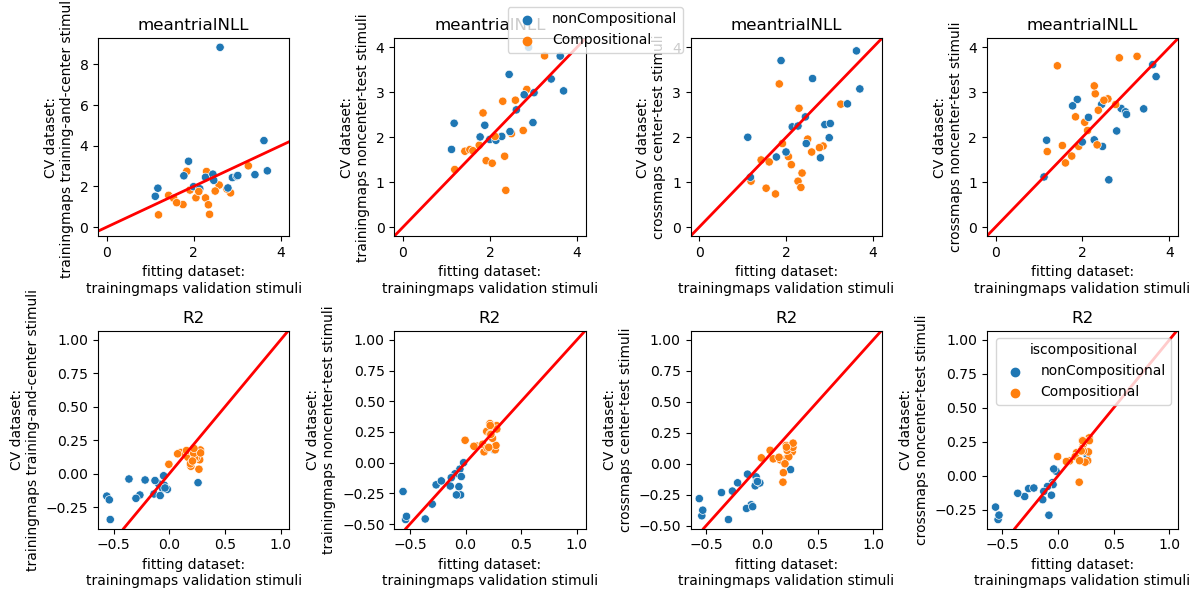

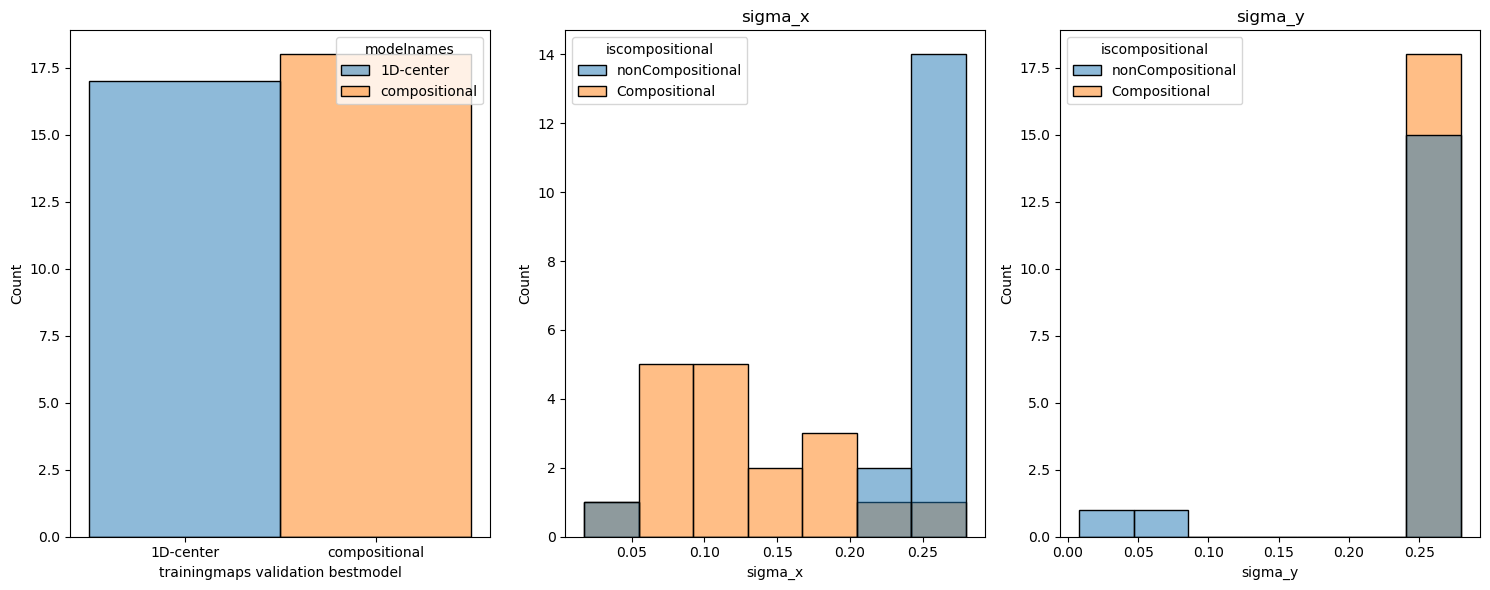

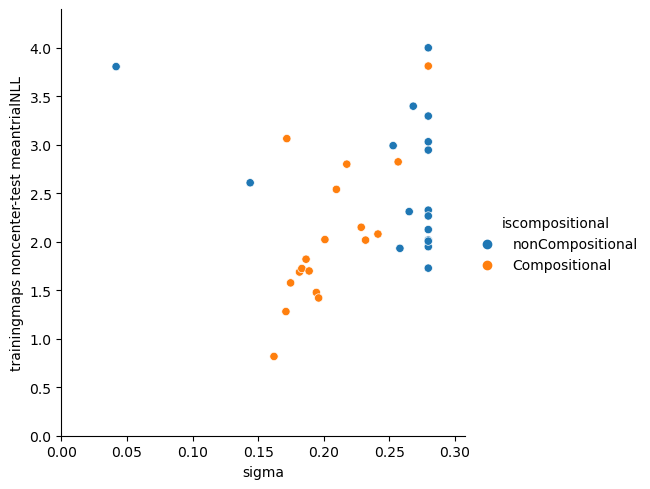

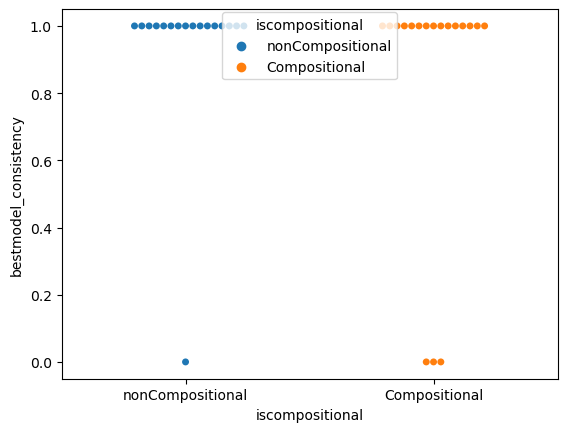

In [ ]:
import numpy as np
import scipy.stats
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import scipy
import itertools
project_dir = "E:\pirate_fmri\Analysis"
import sys
sys.path.append(project_dir)
from src.utils.composition_modelfit import *
from scipy.optimize import minimize
from joblib import Parallel,delayed,dump,load

study_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\3_M2_V2"
data_dir = os.path.join(study_dir,"data","json")
param_dir = os.path.join(study_dir,"data","param")

org_data = pd.read_csv(os.path.join(study_dir,"task_data.csv"))
valid_exptid = np.unique(org_data.subid)

# rescale stim_xy and respone
range_stimxy = [np.max(org_data.stim_x) - np.min(org_data.stim_x),
                np.max(org_data.stim_y) - np.min(org_data.stim_y)]
org_data["stim_xO"] = org_data.stim_x
org_data["stim_yO"] = org_data.stim_y
org_data["resp_xO"] = org_data.resp_x
org_data["resp_yO"] = org_data.resp_y
org_data["stim_x"]  = [np.round(2*a/range_stimxy[0],decimals = 3) for a in org_data.stim_xO.to_numpy()]
org_data["stim_y"]  = [np.round(2*a/range_stimxy[1],decimals = 3) for a in org_data.stim_yO.to_numpy()]
org_data["resp_x"]  = [np.round(2*a/range_stimxy[0],decimals = 3) for a in org_data.resp_xO.to_numpy()]
org_data["resp_y"]  = [np.round(2*a/range_stimxy[0],decimals = 3) for a in org_data.resp_yO.to_numpy()]


putativerespdata_test = []
for id in valid_exptid:
    subdf = org_data[(org_data.subid==id)&(org_data.ctrl_ept==1)].copy().reset_index(drop=True)
    
    # find the final block of each map in test
    n_pretrain_permap = 8
    n_map = 2
    n_refresh_permap = 4
    test_block_idx = n_pretrain_permap*n_map+n_refresh_permap
    sub_testblock_df = subdf[(subdf.expt_session==1)&(subdf.expt_block==test_block_idx)].copy().reset_index(drop=True)
    #sub_testblock_df.groupby(["subid","expt_map","x_axisset","y_axisset","stim_group","istraining","stim_id","stim_x","stim_y"])[["resp_x","resp_y"]].mean().reset_index()
    # the data frame used to derive putative response
    sub_trainingresp=sub_testblock_df[sub_testblock_df.istraining==True].copy().reset_index(drop=True)
    sub_resp=sub_testblock_df.copy()
    
    putative_xs = compose_pattern_from_reference(sub_resp[["stim_x"]].to_numpy(),
                                sub_trainingresp[["resp_x"]].to_numpy(),
                                sub_trainingresp[["stim_x"]].to_numpy(),
                                source_controlfeatures=sub_resp[["x_axisset"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["x_axisset"]].to_numpy()).flatten()
    putative_ys = compose_pattern_from_reference(sub_resp[["stim_y"]].to_numpy(),
                                sub_trainingresp[["resp_y"]].to_numpy(),
                                sub_trainingresp[["stim_y"]].to_numpy(),
                                source_controlfeatures=sub_resp[["y_axisset"]].to_numpy(),
                                reference_controlfeatures=sub_trainingresp[["y_axisset"]].to_numpy()).flatten()
    sub_resp["putative_x"] = [truex if istraining else putativex for putativex,truex,istraining in zip(putative_xs,sub_resp.stim_x.to_numpy(),sub_resp.istraining.to_numpy())]
    sub_resp["putative_y"] = [truey if istraining else putativey for putativey,truey,istraining in zip(putative_ys,sub_resp.stim_y.to_numpy(),sub_resp.istraining.to_numpy())]
    sub_resp["map_axes"] = [f"{x}_{y}" for x,y in sub_resp[["x_axisset","y_axisset"]].to_numpy()]
    putativerespdata_test.append(sub_resp)

putativerespdata_test_df = pd.concat(putativerespdata_test).reset_index(drop=True)
putativerespdata_test_df["iscenter"] = pd.Categorical([x*y==0 for x,y in putativerespdata_test_df[["stim_x","stim_y"]].to_numpy()]).rename_categories(
    {True:"center",False:"noncenter"}
)


################# RUN MODEL FITTING ##############################
run_fit = False
# arena parameters
arena_r = (5 + (1.42*60/53*1.1/2))*(2/range_stimxy[0])
err_tol = 1.05*60/53 *(2/range_stimxy[0]) # take into account the pirate size

# models to fit
model_xystrategies = { # in the form of xstrategy-ystrategy
        "compositional": ["putative-putative"],
        "1D-center":["putative-bias","bias-putative"],
        "1D-random":["putative-random","random-putative"]
    }
model_paramnames = {
    "noncompo-random":[],
    "compositional": ["sigma_x", "sigma_y","lapse_rate"], # "betax", "betay", 
    "1D-center":     ["sigma_x", "sigma_y", "sigma_biasx", "sigma_biasy","lapse_rate"],
    "1D-random":     ["sigma_x", "sigma_y","lapse_rate"]
}
beta_bounds = (0.1,arena_r)
sigma_bounds = (1e-20,err_tol) 
sigmabias_bounds = (1e-20,arena_r)     
mu_bounds = (-arena_r,arena_r)
lapse_bounds = (0,0.1)
model_bounds = {
    "compositional": [sigma_bounds,sigma_bounds,lapse_bounds],
    "1D-center":[sigma_bounds,sigma_bounds,sigmabias_bounds,sigmabias_bounds,lapse_bounds],
    "1D-random":[sigma_bounds,sigma_bounds,lapse_bounds]
}
unique_param_names = np.unique(sum(list(model_paramnames.values()),[]))

fixedparams = {     
                "noncompo-random":{},
                "compositional":  {"betax":1,"betay":1},
                "1D-center":      {"betax":1,"betay":1,"biasx":0, "biasy":0},
                "1D-random":      {"betax":1,"betay":1,"biasx":0, "biasy":0} # "lapse_rate":0.05
            }
all_param_names = np.array(list(unique_param_names) + ["betax", "betay","biasx","biasy"])

outout_fn = "fitted_bhavmodel_parameters_tvsplit_centerality"
if run_fit:
    fit_param = []
    for j,id in enumerate(valid_exptid):
        subdf = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group=="validation")&(putativerespdata_test_df.expt_map.isin([0,1]))].copy().reset_index(drop=True)
        #trainstim_df = putativerespdata_test_df[(putativerespdata_test_df.subid == id)&(putativerespdata_test_df.stim_group=="training")&(putativerespdata_test_df.expt_map.isin([0,1]))].copy().reset_index(drop=True)
        #mu_respx = np.mean(trainstim_df[trainstim_df.stim_x==0].resp_x)
        #mu_respy = np.mean(trainstim_df[trainstim_df.stim_y==0].resp_y)
        #fixedparams["1D-center"].update({"biasx":mu_respx, "biasy":mu_respy})
        
        fit_data = subdf[["resp_x","resp_y","putative_x","putative_y"]].to_numpy()
        
        #estimate starting value for optimisation
        bx, ix, _, _, _  = scipy.stats.linregress(fit_data[:,0], fit_data[:,2])
        by, iy, _, _, _  = scipy.stats.linregress(fit_data[:,1], fit_data[:,3])  
        bx,by = 1,1
        sig_x = np.power(fit_data[:,0] - bx*fit_data[:,2],2).mean()
        sig_y = np.power(fit_data[:,1] - by*fit_data[:,3],2).mean()

        sigbias_x = np.power(fit_data[:,0] - 0,2).mean()
        sigbias_y = np.power(fit_data[:,1] - 0,2).mean()

        model_x0 = {
            "compositional": [sig_x,sig_y,0.05],
            "1D-center":     [sig_x,sig_y,sigbias_x,sigbias_y,0.05],
            "1D-random":     [sig_x,sig_y,0.05]
        }

        all_model_fit = []
        for mname, xystrategies in model_xystrategies.items():
            print(f"\nsub{j+1}/{np.size(valid_exptid)}: {id} {mname}")

            # fit_output = multi_start_optimisation(compute_llr_across_trials,
            #                         bounds=model_bounds[mname],
            #                         args=(model_paramnames[mname],xystrategies,fit_data,fixedparams[mname]),
            #                         Ns=3,n_jobs=1)
            fit_output = wise_start_optimisation(compute_llr_across_trials,
                                    bounds=model_bounds[mname],
                                    args=(model_paramnames[mname],xystrategies,fit_data,fixedparams[mname]),
                                    x0=model_x0[mname],
                                    minimize_args={})
            print(f"  fitted {model_paramnames[mname]} = {fit_output[0]}, nll = {fit_output[1]}")
            all_model_fit.append(fit_output)
        fit_param.append(all_model_fit)
    dump({"subids":valid_exptid,"fit_param":fit_param,"fixedparams":fixedparams},os.path.join(study_dir,f"{outout_fn}.pkl"))


################# CHECK MODEL FIT ##############################
check_fit = True
if check_fit:
    fitted_data  = load(os.path.join(study_dir,f"{outout_fn}.pkl"))
    fixedparams  = fitted_data["fixedparams"]
    valid_exptid = fitted_data["subids"]
    fit_param    = fitted_data["fit_param"]

    model_xystrategies["noncompo-random"] = ["random-random"]

    model_selection_dfs = []
    model_param_dfs = []
    for jid,(id,fit_output) in enumerate(zip(valid_exptid,fit_param)):
        print(f"sub{jid+1}/{len(valid_exptid)}: {id}")
        fitted_param = dict(zip(
            list(model_xystrategies.keys())+["noncompo-random"],
            [o[0] for o in fit_output]+[[]]
        ))

        fitted_nll = dict(zip(
            list(model_xystrategies.keys())+["noncompo-random"],
            [o[1] for o in fit_output]+[[]]
        ))

        sub_df = putativerespdata_test_df[putativerespdata_test_df.subid == id].copy().reset_index(drop=True)
        
        df_split_criteria = { 
            "trainingmaps validation":          (sub_df.expt_map.isin([0,1]))&(sub_df.stim_group == "validation"), # dataset that is used to fit the parameter
            "trainingmaps training-and-center": (sub_df.expt_map.isin([0,1]))&(sub_df.iscenter == "center"),       # for sanity check
            "trainingmaps noncenter-test":      (sub_df.expt_map.isin([0,1]))&(sub_df.iscenter == "noncenter")&(sub_df.stim_group == "test"),    #
            "crossmaps center-test":            (sub_df.expt_map.isin([2,3]))&(sub_df.iscenter == "center"),
            "crossmaps noncenter-test":         (sub_df.expt_map.isin([2,3]))&(sub_df.iscenter == "noncenter"),
        }
        df_splits = {}
        data_splits = {}
        for k,v in df_split_criteria.items():
            df_splits[k] = sub_df[v].copy().reset_index(drop=True)
            data_splits[k] = df_splits[k][["resp_x","resp_y","putative_x","putative_y"]].to_numpy()
        
        data_nll = {}
        data_BIC = {}
        data_R2  = {}
        data_slope = {}
        n_random_sample = 100
        for sgname, ds in data_splits.items():
            data_nll[sgname] = {}
            data_BIC[sgname] = {}
            data_R2[sgname] = {}
            data_slope[sgname] = {}
            for mname, mstrategy in model_xystrategies.items():
                mparam = fitted_param[mname]
                data_nll[sgname][mname] = compute_llr_across_trials(mparam,model_paramnames[mname],model_xystrategies[mname],ds,fixedparams[mname])
                if np.logical_and(mname != "noncompo-random", sgname == "trainingmaps validation"):
                    returned_nll = fitted_nll[mname]
                    assert np.round(data_nll[sgname][mname],4) == np.round(returned_nll,4)
                n_trials = df_splits[sgname].shape[0]
                data_BIC[sgname][mname] = BIC(data_nll[sgname][mname],n_trials,len(mparam))

                param_dict = dict(zip(model_paramnames[mname],fitted_param[mname]))
                param_dict.update(fixedparams[mname])
                null_param_dict = dict(zip(all_param_names[[x not in param_dict.keys() for x in all_param_names]],
                                        [np.nan]*sum([x not in param_dict.keys() for x in all_param_names])))
                param_dict.update(null_param_dict)
                # predicted_resp is of shape (n_random_sample,2,ds.shape[0])
                predicted_resp = sample_response(param_dict, mstrategy, ds, sample_size=n_random_sample,seed=None)
                true_resp = ds[:,[0,1]]
                slp = [calculate_regression(predicted_resp[ksample,:,:].T, true_resp) for ksample in range(n_random_sample)]
                r2 = [calculate_r_squared_bivariate(predicted_resp[ksample,:,:].T, true_resp) for ksample in range(n_random_sample)]
                data_R2[sgname][mname] = np.mean(r2)
                data_slope[sgname][mname] = np.mean(slp)

        modelnames = list(model_xystrategies.keys())
        model_param_df_dict = {"modelnames":modelnames}
        for pname in unique_param_names:
            model_param_df_dict[pname] = [fitted_param[mname][model_paramnames[mname].index(pname)] if pname in model_paramnames[mname] else np.nan for mname in modelnames]
        
        for sgname in data_nll.keys():
            n_trials = df_splits[sgname].shape[0]            
            model_param_df_dict[f"{sgname} BIC"]          = [data_BIC[sgname][mname] for mname in modelnames]
            model_param_df_dict[f"{sgname} R2"]           = [data_R2[sgname][mname] for mname in modelnames]
            model_param_df_dict[f"{sgname} slope(true~pred)"] = [data_slope[sgname][mname] for mname in modelnames]
            model_param_df_dict[f"{sgname} meantrialNLL"] = [data_nll[sgname][mname]/n_trials for mname in modelnames]
            bmodel = list(data_BIC[sgname].keys())[np.argmin(list(data_BIC[sgname].values()))]
            model_param_df_dict[f"{sgname} bestmodel"] = [bmodel] * len(modelnames)

        model_param_dfs.append(
            pd.DataFrame(model_param_df_dict).assign(subid=id)
        )

    model_param_df = pd.concat(model_param_dfs,axis=0).reset_index(drop=True)
    model_param_df["iscompositional"] = pd.Categorical(
        model_param_df["trainingmaps validation bestmodel"] == "compositional"
    ).rename_categories({True: 'Compositional', False: 'nonCompositional'})
    model_param_df["bestmodel_consistency"] = model_param_df["trainingmaps validation bestmodel"] == model_param_df["trainingmaps noncenter-test bestmodel"]
        
    compositional_ids = np.unique(model_param_df[model_param_df.iscompositional=="Compositional"].subid)
    remove_sub = ["RcwaTugr8Fiz","FZy8PSATlIm3","SyZeCxfhSm2n","bHAKEOQOX39l"]
    keep_sub = [id for id in valid_exptid if id not in remove_sub]

    compositional_ids = [id for id in compositional_ids if id in keep_sub]
    noncompositional_ids = [id for id in keep_sub if id not in compositional_ids]

    best_fit_df = model_param_df[(model_param_df.modelnames==model_param_df["trainingmaps validation bestmodel"])&(~model_param_df.subid.isin(remove_sub))].copy().reset_index()

    x_dsname = 'trainingmaps validation' 
    compare_dsnames = ['trainingmaps training-and-center',
                        'trainingmaps noncenter-test',
                        'crossmaps center-test',
                        'crossmaps noncenter-test']
    compare_metrics = ["meantrialNLL","R2"]
    ax_lims = [[0,4],[0,1]]
    fig_modelfit, axes_modelfit = plt.subplots(len(compare_metrics),len(compare_dsnames),figsize=(12,6))
    for j, mtc in enumerate(compare_metrics):
        for k, y_dsname in enumerate(compare_dsnames):
            sns.scatterplot(best_fit_df,
                            x = f"{x_dsname} {mtc}",
                            y = f"{y_dsname} {mtc}",
                            hue="iscompositional",
                            ax = axes_modelfit[j,k])
            axes_modelfit[j,k].set_xlabel(f"fitting dataset:\n{x_dsname} stimuli")
            axes_modelfit[j,k].set_ylabel(f"CV dataset:\n{y_dsname} stimuli")
            axes_modelfit[j,k].set_title(mtc)
            axes_modelfit[j,k].axline((0, 0), (ax_lims[j][1], ax_lims[j][1]), linewidth=2, color='r')
            if np.logical_and(j == len(compare_metrics)-1,k == len(compare_dsnames)-1):
                figlgdhandles, figlgdlabels = axes_modelfit[j,k].get_legend_handles_labels()
            else:
                axes_modelfit[j,k].get_legend().remove()
            #axes_modelfit[j,k].set_aspect(1)
            #axes_modelfit[j,k].set_xlim(ax_lims[j])
            #axes_modelfit[j,k].set_ylim(ax_lims[j])
    
    fig_modelfit.legend(figlgdhandles, figlgdlabels, loc='upper center')
    fig_modelfit.tight_layout()

    pparams = ['sigma_x', 'sigma_y']
    fig_typedist, axes_typedist = plt.subplots(1,1+len(pparams),figsize=(15,6))
    sns.histplot(best_fit_df,
                x="trainingmaps validation bestmodel",
                hue="modelnames",
                ax=axes_typedist[0])
    for k,pp in enumerate(pparams):
        sns.histplot(best_fit_df,
                x=pp,
                hue="iscompositional",
                ax=axes_typedist[k+1])
        axes_typedist[k+1].set_title(pp)
    fig_typedist.tight_layout()

    best_fit_df["sigma"] = [sx if np.isnan(sy) else sy if np.isnan(sx) else (sx+sy)/2 for sx,sy in best_fit_df[["sigma_x","sigma_y"]].to_numpy()]
    gs_sigma = sns.relplot(
        best_fit_df,
        x="sigma",
        y="trainingmaps noncenter-test meantrialNLL",
        hue="iscompositional"
        )
    for ax in gs_sigma.axes.flatten():
        ax.set_xlim([0,1.1*err_tol])
        ax.set_ylim([0,1.1*np.max(best_fit_df["trainingmaps noncenter-test meantrialNLL"])])
        #ax.axline(xy1=[0,0],xy2=[13,13],c="k")

    fig_consistency,ax_consistency = plt.subplots(1,1)
    sns.swarmplot(
        best_fit_df,
        x="iscompositional",
        y="bestmodel_consistency",
        hue="iscompositional",
        ax=ax_consistency)
    sns.move_legend(ax_consistency,
                    loc="upper center",
                    bbox_to_anchor=(0.5,1.01))

In [ ]:
compositional_ids

['CIHofsSopOIK',
 'Dg4Z9j33pfaS',
 'ESg8ssLdSeH4',
 'GsxAkjUf8C3h',
 'H4wAVOPtFkAT',
 'H8eke7rnGDxC',
 'Kp1cBGB5cVB1',
 'MJQxtcr3UsX3',
 'NzlkkO2C4ye1',
 'RAVplkWmRefi',
 'WOcbffbfi7mI',
 'YHFTln2WomAo',
 'aprCv5rFL8pN',
 'bjjQPvQtZ124',
 'rRFXwgxK5NUQ',
 'rkUOlfyTeHAM',
 'tXmcOBQcBq5X',
 'xZoeR59rDXFN']

In [ ]:
sorted_compositional_ids = sorted(compositional_ids, key=str.casefold)

In [ ]:
sorted_compositional_ids

['aprCv5rFL8pN',
 'bjjQPvQtZ124',
 'CIHofsSopOIK',
 'Dg4Z9j33pfaS',
 'ESg8ssLdSeH4',
 'GsxAkjUf8C3h',
 'H4wAVOPtFkAT',
 'H8eke7rnGDxC',
 'Kp1cBGB5cVB1',
 'MJQxtcr3UsX3',
 'NzlkkO2C4ye1',
 'RAVplkWmRefi',
 'rkUOlfyTeHAM',
 'rRFXwgxK5NUQ',
 'tXmcOBQcBq5X',
 'WOcbffbfi7mI',
 'xZoeR59rDXFN',
 'YHFTln2WomAo']

In [ ]:
best_fit_df[best_fit_df.subid=="G8yNoK8WMiwt"]

,index,modelnames,lapse_rate,sigma_biasx,sigma_biasy,sigma_x,sigma_y,trainingmaps validation BIC,trainingmaps validation R2,trainingmaps validation slope(true~pred),...,crossmaps center-test bestmodel,crossmaps noncenter-test BIC,crossmaps noncenter-test R2,crossmaps noncenter-test slope(true~pred),crossmaps noncenter-test meantrialNLL,crossmaps noncenter-test bestmodel,subid,iscompositional,bestmodel_consistency,sigma
4,21,1D-center,0.1,0.628217,0.409167,0.017518,0.06587,129.553133,-0.051608,0.180041,...,1D-center,248.663998,-0.051783,0.157504,3.614614,compositional,G8yNoK8WMiwt,nonCompositional,True,0.041694
